In [1]:
import numpy as np

In [ ]:
np.random.seed(1440)

In [2]:
def dilser(low=0.001, limit=100.0, dilfactor = 2.0):
    """Returns a list containing a dilution series that ranges from
    "low" to "limit" by "dilfactor".
    """
    a = [low]
    while a[-1] <= limit:
        a.append(a[len(a)-1]*dilfactor)
    
    return np.array(a)


In [3]:
lig = dilser()

a = np.delete(lig,[15,16])

b = np.delete(lig,[14,17])

c = np.delete(lig,[13,15])

ligset = np.array([lig,a,lig,b,c])

In [4]:
rtots = np.array([0.001,0.005, 0.01, 0.02, 0.05])

sim_parms = dict({'k11':3.7, 'k21':1.8, 'k22':0.12, 'l20':293.0})

parmvec = [3.7,1.8,0.12,293.0]

In [5]:
def wyman_sim_parmvec(parm,lig,rtot):
    """ Generates bound fraction for Wyman model given parameters and returns as 
    nested array simulated dataset  
    parm is a 1-D numpy array that must describe [k11,k21,k22,l20]
    lig is a 1-D array or 1-D array of 1-D arrays of ligand concentrations
    rtot is a 1-D numpy array of total receptor concentrations for each data set
    size of rtot and lig must match 
    """
    k11 = parm[0]
    k21 = parm[1]
    k22 = parm[2]
    l20 = parm[3]
    
    holder = []
    
    for i in range(lig.size):
        rfree = (((-1 - k11*lig[i]) + \
        (np.sqrt((1 + k11*lig[i])**2 + 8*l20*rtot[i]*(1 + k21*lig[i] + \
        k21*k22*(lig[i]**2)))))/(4*l20*(1 + k21*lig[i] + k21*k22*(lig[i]**2))))
        
        bfrac = (k11*lig[i] + l20*k21*rfree*lig[i] + \
        2*l20*k21*k22*rfree*(lig[i]**2))/(1 + 2*l20*rfree + k11*lig[i] + \
        2*l20*k21*rfree*lig[i] + 2*l20*k21*k22*rfree*(lig[i]**2))
        
        holder.append(bfrac)
        
    return np.array(holder)

In [6]:
bindset = wyman_sim_parmvec(parmvec,ligset,rtots)

In [70]:
#explicit noise array -- so I can recreate
np.random.seed(5785)
noiseset = np.array([np.random.normal(1.0,0.03,bindset[i].size) for i in range(bindset.size)])

In [71]:
noiseset

array([ array([ 1.00617918,  0.99023274,  1.00787412,  1.0138261 ,  0.98418485,
        0.9947373 ,  0.93270117,  1.00012207,  1.02910715,  0.99626626,
        1.02157297,  0.97526078,  0.94367772,  0.97143708,  0.99853889,
        1.05128943,  1.02842383,  0.96899232]),
       array([ 1.01087044,  0.99177023,  0.9665545 ,  1.01452523,  0.94225941,
        0.96956474,  1.01542936,  0.98359099,  1.0034616 ,  1.04211599,
        1.0002157 ,  0.98595672,  1.00290611,  1.03279034,  0.93744478,
        1.03128241]),
       array([ 1.06715146,  1.02350247,  1.02754237,  0.95969655,  1.0405557 ,
        0.97750069,  0.94308836,  1.04585481,  1.03039661,  1.00306248,
        1.05760845,  0.99167362,  0.94593037,  0.98543285,  1.01803083,
        0.98665579,  1.04681933,  1.01407121]),
       array([ 1.029253  ,  1.01940108,  0.9856499 ,  1.02474087,  1.00091153,
        1.01694388,  0.99703627,  1.03541353,  1.00592349,  0.96563508,
        0.98967749,  0.99979111,  0.99889777,  0.95396244,  0

In [72]:
bindset_n = noiseset*bindset

In [73]:
%matplotlib inline

In [74]:
import matplotlib.pyplot as plt

In [75]:
clr = ['b','g','r','c','m']

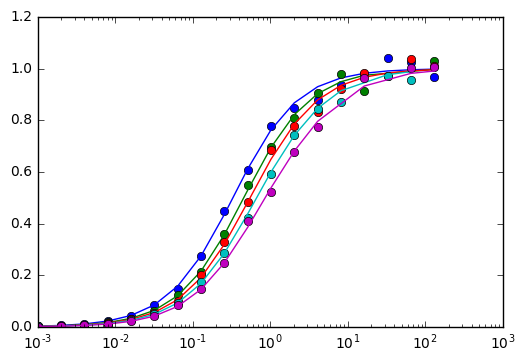

In [76]:
for i in range(bindset_n.size):
    plt.semilogx(ligset[i],bindset_n[i],'o',color=clr[i])
    plt.semilogx(ligset[i],bindset[i],color=clr[i])

In [77]:
#define an objective function for use with lmfit (must mesh with lmfit.Parameter class)
def wyman_obj_lmfit(parm,lig,data,rtot,eps=None):
    """maximizes vector ops"""
    k11 = parm['k11']
    k21 = parm['k21']
    k22 = parm['k22']
    l20 = parm['l20']
    
    ligc = np.concatenate(lig)
    datac = np.concatenate(data)
    
    rfree = (((-1 - k11*ligc)) + \
    (np.sqrt(np.concatenate((np.square((1 + k11*lig)) + \
    8.*l20*rtot*(1 + k21*lig + k21*k22*(np.square(lig)))))))) \
    / (4*l20*(1 + k21*ligc + k21*k22*(np.square(ligc))))    
       
    bfrac = (k11*ligc + l20*k21*rfree*ligc + \
    2*l20*k21*k22*rfree*(np.square(ligc))) \
    / (1 + 2*l20*rfree + k11*ligc + \
    2*l20*k21*rfree*ligc + 2*l20*k21*k22*rfree*(np.square(ligc)))
    
    residual = (bfrac - datac)
    
    if eps is None:
        return residual
    else:
        weights = 1/np.square(np.concatenate(eps))
        return (residual*weights)

In [78]:
import lmfit

In [79]:
parms = lmfit.Parameters()

In [80]:
parms.add('k11', value=10., min=0.01)
parms.add('k21', value=10., min=0.01)
parms.add('k22', value=10., min=0.01)
parms.add('l20', value=100., min=0.01)

In [81]:
wym_min = lmfit.Minimizer(wyman_obj_lmfit,parms,fcn_args=(ligset,bindset_n,rtots))

In [82]:
wym_res = wym_min.minimize(method='least_squares')

In [83]:
lmfit.report_fit(wym_res)

[[Fit Statistics]]
    # function evals   = 14
    # data points      = 84
    # variables        = 4
    chi-square         = 0.027
    reduced chi-square = 0.000
    Akaike info crit   = -666.298
    Bayesian info crit = -656.575
[[Variables]]
    k11:   3.68721061 (init= 10)
    k21:   2.02920909 (init= 10)
    k22:   0.10496837 (init= 10)
    l20:   292.646499 (init= 100)
[[Correlations]] (unreported correlations are <  0.100)


In [84]:
bindset_fit = wyman_sim_parmvec(wym_res.x,ligset,rtots)

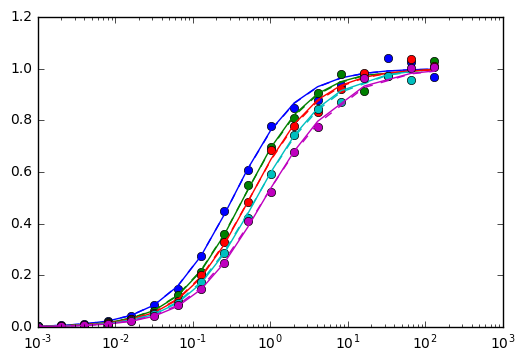

In [85]:
for i in range(bindset_n.size):
    plt.semilogx(ligset[i],bindset_n[i],'o',color=clr[i])
    plt.semilogx(ligset[i],bindset_fit[i],'--',color=clr[i])
    plt.semilogx(ligset[i],bindset[i],color=clr[i])

In [86]:
err = 0.03*bindset_n

In [87]:
wym_min_wts = lmfit.Minimizer(wyman_obj_lmfit,parms,fcn_args=(ligset,bindset_n,rtots,err))

In [88]:
wym_res_wts = wym_min_wts.minimize()

In [89]:
lmfit.report_fit(wym_res_wts)

[[Fit Statistics]]
    # function evals   = 108
    # data points      = 84
    # variables        = 4
    chi-square         = 1277685415.268
    reduced chi-square = 15971067.691
    Akaike info crit   = 1397.150
    Bayesian info crit = 1406.873
[[Variables]]
    k11:   3.57241522 +/- 0.096144 (2.69%) (init= 10)
    k21:   1.88996919 +/- 0.041522 (2.20%) (init= 10)
    k22:   0.01000015 +/- 0.539204 (5391.96%) (init= 10)
    l20:   244.265016 +/- 32.62330 (13.36%) (init= 100)
[[Correlations]] (unreported correlations are <  0.100)
    C(k11, l20)                  =  0.961 
    C(k21, l20)                  =  0.852 
    C(k11, k21)                  =  0.697 


In [90]:
parmsols = np.array([10.,10.,1.,100.])

In [91]:
#define an objective function for use with scipy optimize (obviates parameter class)
def wyman_obj_vecmin(parm,lig,data,rtot,eps=None):
    k11 = parm[0]
    k21 = parm[1]
    k22 = parm[2]
    l20 = parm[3]
    
    ligc = np.concatenate(lig)
    datac = np.concatenate(data)
    
    rfree = (((-1 - k11*ligc)) + \
    (np.sqrt(np.concatenate((np.square((1 + k11*lig)) + \
    8.*l20*rtot*(1 + k21*lig + k21*k22*(np.square(lig)))))))) \
    / (4*l20*(1 + k21*ligc + k21*k22*(np.square(ligc))))    
       
    bfrac = (k11*ligc + l20*k21*rfree*ligc + \
    2*l20*k21*k22*rfree*(np.square(ligc))) \
    / (1 + 2*l20*rfree + k11*ligc + \
    2*l20*k21*rfree*ligc + 2*l20*k21*k22*rfree*(np.square(ligc)))
    
    residual = (bfrac - datac)

    if eps is None:
        return residual
    else:
        weights = 1/np.square(np.concatenate(eps))
        return (residual*weights)

In [92]:
from scipy import optimize

In [93]:
res_lsq = optimize.least_squares(wyman_obj_vecmin,parmvec,args=(ligset,bindset_n,rtots))

In [94]:
res_lsq.x

array([  3.68715259e+00,   2.02918776e+00,   1.04949219e-01,
         2.92620291e+02])

In [51]:
bounds=((0.,0.,0.,0.),(100.,100.,100.,1000.))

In [52]:
res_lsq_bounds = optimize.least_squares(wyman_obj_vecmin,parmsols,bounds=bounds,args=(ligset,bindset_n,rtots))

In [53]:
res_lsq_bounds.x

array([  3.78237338e+00,   2.29785087e+00,   2.27813924e-01,
         4.51066878e+02])

In [55]:
res_lsq_lm = optimize.least_squares(wyman_obj_vecmin,res_lsq_bounds2.x,method='lm',args=(ligset,bindset_n,rtots))

In [56]:
res_lsq_lm.x

array([  3.78237150e+00,   2.29785164e+00,   2.27813603e-01,
         4.51065901e+02])

In [63]:
res_lsq_bounds_wts = optimize.least_squares(wyman_obj_vecmin,parmsols,bounds=bounds,args=(ligset,bindset_n,rtots,err))

In [64]:
res_lsq_bounds_wts.x

array([   3.86270936,    1.87589445,    1.46333892,  391.28235496])

In [65]:
help(wyman_sim_parmvec)

Help on function wyman_sim_parmvec in module __main__:

wyman_sim_parmvec(parm, lig, rtot)
    Generates bound fraction for Wyman model given parameters and returns as 
    nested array simulated dataset  
    parm is a 1-D numpy array that must describe [k11,k21,k22,l20]
    lig is a 1-D array or 1-D array of 1-D arrays of ligand concentrations
    rtot is a 1-D numpy array of total receptor concentrations for each data set
    size of rtot and lig must match



In [66]:
bindset_fit_wts = wyman_sim_parmvec(res_lsq_bounds_wts.x,ligset,rtots)

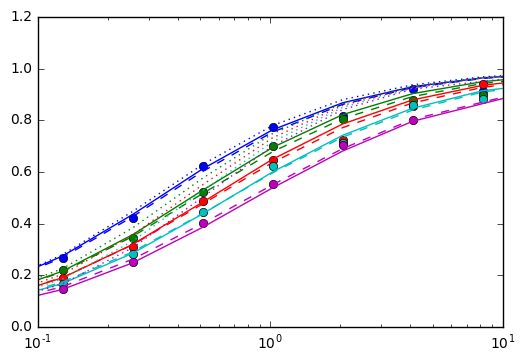

In [69]:
for i in range(bindset_n.size):
    plt.semilogx(ligset[i],bindset_n[i],'o',color=clr[i])
    plt.semilogx(ligset[i],bindset_fit[i],'--',color=clr[i])
    plt.semilogx(ligset[i],bindset_fit_wts[i],':',color=clr[i])
    plt.semilogx(ligset[i],bindset[i],color=clr[i])
    plt.xlim(0.1,10)

In [316]:
def lnprob_lmfit(parm,lig,data,rtot,eps):
    return -0.5 * np.sum((wyman_obj_lmfit(parm,lig,data,rtot,eps))**2 + np.log(np.concatenate(2 * np.pi * eps**2)))

In [281]:
mcmc2 = lmfit.Minimizer(lnprob_lmfit, wym_res.params, fcn_args=(ligset,bindset_n,rtots))

In [282]:
result_mc2 = mcmc2.emcee(burn=50, steps=500, is_weighted=False, params=wym_res.params)

TypeError: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'

In [283]:
help(lnprob_lmfit)

Help on function lnprob_lmfit in module __main__:

lnprob_lmfit(parm, lig, data, rtot, eps=None)



In [285]:
lnprob_lmfit(wym_res_wts.params,ligset,bindset_n,rtots)

TypeError: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'

In [289]:
bindset_n

array([ array([ 0.00294764,  0.00506857,  0.01171443,  0.02409477,  0.04242633,
        0.0829698 ,  0.15317205,  0.27473908,  0.36549305,  0.6539502 ,
        0.71759209,  0.91005245,  0.88537934,  0.9310163 ,  0.95598881,
        0.99349177,  0.95576054,  0.997432  ]),
       array([ 0.00225324,  0.00402609,  0.00881405,  0.01733223,  0.03291965,
        0.06319228,  0.11235852,  0.20887912,  0.38198282,  0.56051093,
        0.71713524,  0.76667476,  0.93002206,  0.93425922,  1.00252446,
        1.01656369]),
       array([ 0.00198167,  0.00362166,  0.00732817,  0.01522919,  0.02776383,
        0.05429953,  0.10332925,  0.18607243,  0.29019902,  0.47129974,
        0.67020322,  0.73241554,  0.86022498,  1.03769857,  0.98068277,
        0.99600532,  1.03134576,  1.0060786 ]),
       array([ 0.00160614,  0.00304004,  0.00620276,  0.01276486,  0.02468889,
        0.04878889,  0.09258958,  0.17495165,  0.28838219,  0.44356135,
        0.53627062,  0.71793977,  0.82754191,  0.86987028,  1

In [290]:
help(wyman_obj_vecmin)

Help on function wyman_obj_vecmin in module __main__:

wyman_obj_vecmin(parm, lig, data, rtot, eps=None)
    #define an objective function for use with scipy optimize (obviates parameter class)



In [291]:
help(wyman_obj_lmfit)

Help on function wyman_obj_lmfit in module __main__:

wyman_obj_lmfit(parm, lig, data, rtot, eps=None)
    maximizes vector ops



In [293]:
parmvec

[3.7, 1.8, 0.12, 293.0]

In [295]:
parms

Parameters([('k11', <Parameter 'k11', 10.0, bounds=[0.01:inf]>),
            ('k21', <Parameter 'k21', 10.0, bounds=[0.01:inf]>),
            ('k22', <Parameter 'k22', 10.0, bounds=[0.01:inf]>),
            ('l20', <Parameter 'l20', 100.0, bounds=[0.01:inf]>)])

In [297]:
res_lsq_lm.x

array([  3.47876751e+00,   1.92108054e+00,   9.65545823e-02,
         2.56074480e+02])

In [299]:
wym_res.params

Parameters([('k11', <Parameter 'k11', 3.4786841406531743, bounds=[0.01:inf]>),
            ('k21', <Parameter 'k21', 1.9210336218861064, bounds=[0.01:inf]>),
            ('k22',
             <Parameter 'k22', 0.096525802091210672, bounds=[0.01:inf]>),
            ('l20', <Parameter 'l20', 256.03863543193353, bounds=[0.01:inf]>)])

In [305]:
np.sum(wyman_obj_vecmin(res_lsq_lm.x,ligset,bindset_n,rtots))

18165.178902933869

In [308]:
np.sum(wyman_obj_lmfit(wym_res_wts.params,ligset,bindset_n,rtots,err))

8140.3164228574615

In [309]:
help(lnprob_lmfit)

Help on function lnprob_lmfit in module __main__:

lnprob_lmfit(parm, lig, data, rtot, eps=None)



In [317]:
lnprob_lmfit(wym_min.params,ligset,bindset_n,rtots,err)

-1783429281698.3804

In [318]:
parmsols

array([  10.,   10.,    1.,  100.])

In [319]:
parms

Parameters([('k11', <Parameter 'k11', 10.0, bounds=[0.01:inf]>),
            ('k21', <Parameter 'k21', 10.0, bounds=[0.01:inf]>),
            ('k22', <Parameter 'k22', 10.0, bounds=[0.01:inf]>),
            ('l20', <Parameter 'l20', 100.0, bounds=[0.01:inf]>)])

In [320]:
def lnprob_vecmin(parm,lig,data,rtot,eps):
    return -0.5 * np.sum((wyman_obj_vecmin(parm,lig,data,rtot,eps))**2 + np.log(np.concatenate(2 * np.pi * eps**2)))

In [321]:
parmvec

[3.7, 1.8, 0.12, 293.0]

In [322]:
lnprob_vecmin(parmvec,ligset,bindset_n,rtots,err)

-321470237.35118878

In [323]:
lnprob_lmfit(parms,ligset,bindset_n,rtots,err)

-1783429281698.3804

In [324]:
parms

Parameters([('k11', <Parameter 'k11', 10.0, bounds=[0.01:inf]>),
            ('k21', <Parameter 'k21', 10.0, bounds=[0.01:inf]>),
            ('k22', <Parameter 'k22', 10.0, bounds=[0.01:inf]>),
            ('l20', <Parameter 'l20', 100.0, bounds=[0.01:inf]>)])

In [325]:
parms_vec=np.array([10.,10.,10.,100.])

In [327]:
type(parms_vec)

numpy.ndarray

In [328]:
lnprob_vecmin(parms_vec,ligset,bindset_n,rtots,err)

-1783429281698.3804

In [329]:
optimize.minimize(lnprob_vecmin,parms_vec,args=(ligset,bindset_n,rtots,err))

/Users/michael/miniconda3/envs/fitter/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in sqrt
/Users/michael/miniconda3/envs/fitter/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in sqrt
/Users/michael/miniconda3/envs/fitter/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in sqrt
/Users/michael/miniconda3/envs/fitter/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in sqrt


      fun: nan
 hess_inv: array([[ 3.40989472,  2.39004325, -0.55674508,  1.64349459],
       [ 2.39004325,  3.31183563, -0.45644814,  1.36732096],
       [-0.55674508, -0.45644814,  0.97208388,  0.04986062],
       [ 1.64349459,  1.36732096,  0.04986062,  0.94212343]])
      jac: array([ nan,  nan,  nan,  nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1338
      nit: 2
     njev: 223
   status: 2
  success: False
        x: array([ 26621337.17587134,  25420135.1608399 ,  -4544229.45613764,
        13748460.12286596])

In [331]:
def neg_lnprob_vec(parms,ligset,bindset_n,rtots,err):
    return (-1*(lnprob_vecmin(parms,ligset,bindset_n,rtots,err)))

In [332]:
neg_lnprob_vec(parms_vec,ligset,bindset_n,rtots,err)

1783429281698.3804

In [334]:
optimize.minimize(neg_lnprob_vec,parms_vec,args=(ligset,bindset_n,rtots,err),method='SLSQP')

     fun: 50485937584583504.0
     jac: array([ 0.,  0.,  0.,  0.,  0.])
 message: 'Optimization terminated successfully.'
    nfev: 22
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ -2.43318794e+08,  -2.03398015e+08,  -5.80088086e+06,
         4.23047897e+06])

In [336]:
bnds = ((0,None),(0,None),(0,None),(0,None))

In [346]:
optimize.minimize(neg_lnprob_vec,parms_vec,args=(ligset,bindset_n,rtots,err),bounds=((0,None),(0,None),(0,None),(0,None)))

      fun: 232703333.58760351
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.66406345e+03,   5.96940517e+03,   4.54884768e+05,
        -5.06639481e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 245
      nit: 41
   status: 0
  success: True
        x: array([   3.32097422,    1.43095959,    0.        ,  135.14857375])

In [347]:
lnlik_fit_wts = optimize.minimize(neg_lnprob_vec,parms_vec,args=(ligset,bindset_n,rtots,err),bounds=((0,None),(0,None),(0,None),(0,None)))

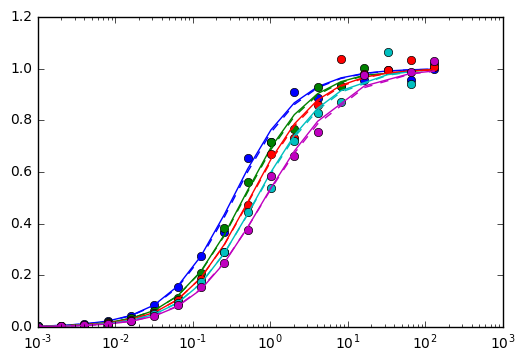

In [345]:
for i in range(bindset_n.size):
    plt.semilogx(ligset[i],bindset_n[i],'o',color=clr[i])
    plt.semilogx(ligset[i],bindset_fit[i],'--',color=clr[i])
    plt.semilogx(ligset[i],bindset[i],color=clr[i])

In [349]:
bindset_mle_fit = wyman_sim_parmvec(lnlik_fit_wts.x,ligset,rtots)

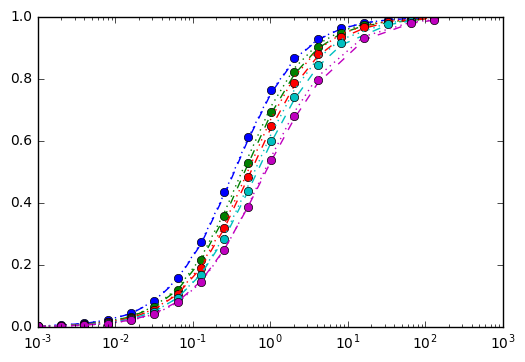

In [364]:
for i in range(bindset_n.size):
    #plt.semilogx(ligset[i],bindset_n[i],'o',color=clr[i])
    plt.semilogx(ligset[i],bindset_fit[i],'--',color=clr[i])
    plt.semilogx(ligset[i],bindset[i],'o',color=clr[i])
    plt.semilogx(ligset[i],bindset_mle_fit[i],':',color=clr[i])

In [351]:
bindset

array([ array([ 0.00287218,  0.0057293 ,  0.01139886,  0.02256218,  0.04420898,
        0.08495766,  0.15750031,  0.27442734,  0.43494373,  0.61140532,
        0.76276266,  0.86736558,  0.92969257,  0.9637874 ,  0.98162164,
        0.99074192,  0.99535363,  0.99767247]),
       array([ 0.00212201,  0.00423545,  0.00843679,  0.01673873,  0.03295043,
        0.06388646,  0.12039349,  0.21575195,  0.3567863 ,  0.52877848,
        0.69457034,  0.82154023,  0.90281887,  0.9492021 ,  0.97402094,
        0.99668726]),
       array([ 0.00183875,  0.00367067,  0.00731417,  0.01452088,  0.02862117,
        0.05563083,  0.10532975,  0.19035641,  0.3191859 ,  0.4825415 ,
        0.64899583,  0.78533335,  0.87867192,  0.93494879,  0.96622051,
        0.98277258,  0.99129847,  0.99562683]),
       array([ 0.0016043 ,  0.00320301,  0.00638376,  0.0126794 ,  0.02501369,
        0.04870285,  0.09251507,  0.16819537,  0.28486929,  0.43720977,
        0.5996735 ,  0.741466  ,  0.84618727,  0.91418393,  0

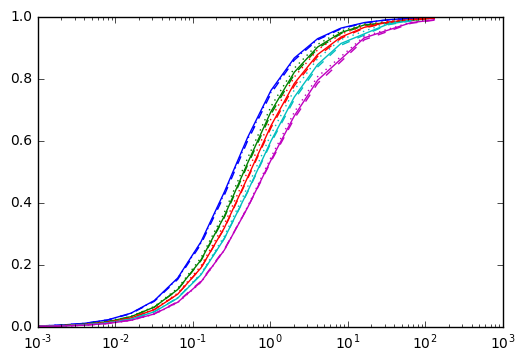

In [361]:
for i in range(bindset_n.size):
    #plt.semilogx(ligset[i],bindset_n[i],'o',color=clr[i])
    plt.semilogx(ligset[i],bindset_fit[i],'--',color=clr[i])
    plt.semilogx(ligset[i],bindset[i],color=clr[i])
    plt.semilogx(ligset[i],bindset_mle_fit[i],':',color=clr[i])

In [363]:
a,b,c = 'h'

ValueError: not enough values to unpack (expected 3, got 1)

In [365]:
ligset

array([ array([  1.00000000e-03,   2.00000000e-03,   4.00000000e-03,
         8.00000000e-03,   1.60000000e-02,   3.20000000e-02,
         6.40000000e-02,   1.28000000e-01,   2.56000000e-01,
         5.12000000e-01,   1.02400000e+00,   2.04800000e+00,
         4.09600000e+00,   8.19200000e+00,   1.63840000e+01,
         3.27680000e+01,   6.55360000e+01,   1.31072000e+02]),
       array([  1.00000000e-03,   2.00000000e-03,   4.00000000e-03,
         8.00000000e-03,   1.60000000e-02,   3.20000000e-02,
         6.40000000e-02,   1.28000000e-01,   2.56000000e-01,
         5.12000000e-01,   1.02400000e+00,   2.04800000e+00,
         4.09600000e+00,   8.19200000e+00,   1.63840000e+01,
         1.31072000e+02]),
       array([  1.00000000e-03,   2.00000000e-03,   4.00000000e-03,
         8.00000000e-03,   1.60000000e-02,   3.20000000e-02,
         6.40000000e-02,   1.28000000e-01,   2.56000000e-01,
         5.12000000e-01,   1.02400000e+00,   2.04800000e+00,
         4.09600000e+00,   8.19200